In [1]:
import os
os.chdir('/workspace/oct_ca_seg')

In [2]:
#export
from fastai.vision import *
from fastai.metrics import *
import torch.nn as nn
import numpy as np
import PIL.Image as pil
import torch.functional as F
from fastai.utils.mem import *
from pathlib import Path
import itertools
import sys

In [3]:
#export
import seg_model.src.model as m
import seg_model.src.jutils as j
import seg_model.src.options as o
from oct_ca.exp.nb_caps import *

In [4]:
data_path = Path('/workspace/oct_ca_seg/data_oct')

In [5]:
valid_names = list(np.load(Path('/workspace/oct_ca_seg/runsaves/Final1-pawsey/analysis/testNAMES.npy')))

In [6]:
for i, name in enumerate(valid_names):
    name = Path(data_path/('images/' + name[:-4] + '.jpg'))
    valid_names[i] = name

In [7]:
ItemList(valid_names)[0]

PosixPath('/workspace/oct_ca_seg/data_oct/images/0004165.jpg')

get the train and valid indicies from our testnames save

In [22]:
%%time

allnames = get_image_files(data_path/'images')
trainidx = []
valididx = []
for i, name in enumerate(allnames):
    if name in valid_names: valididx.append(i)
    else: trainidx.append(i)

KeyboardInterrupt: 

In [23]:
len(trainidx), len(valididx), valididx[0:10]

(2494, 591, [0, 1, 2, 5, 6, 7, 16, 19, 26, 34])

In [10]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_oct_mask(fn)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [11]:
path_img = data_path/'images'

get_y_fn = lambda x: data_path/'labels'/x.name

saved_us, saved_stds = ([0.2158, 0.1964, 0.1908], [0.0418, 0.0194, 0.0138])
saved_stats = (saved_us, saved_stds)

src = (SegItemListCustom.from_folder(path_img)
       .split_by_idxs(train_idx=trainidx, valid_idx=valididx)
       .label_from_func(get_y_fn,classes=['background','lumen']))

metrics=[acc,sens,spec,mydice]
size=256
bs=1
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=4)
        .normalize(saved_stats))

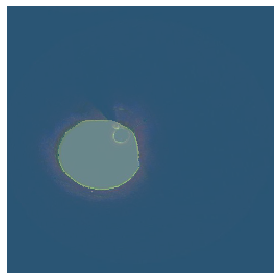

In [12]:
data.show_batch()

In [13]:
#export
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

In [14]:
class OptionsHack():
    def __init__(self, dictionary):
        
        for k,v in dictionary.items():
            setattr(self, k, v)

In [15]:
opts = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'comet': False,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'device': 'cuda',
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 1,
'inputchannels': 3,
'la': 0.1,
'lb': 1,
'lc': 0.05,
'loadcheckpoint': '/workspace/oct_ca_seg/runsaves/Final1-pawsey/checkpoints/checkpoint.pt',
'location': 'pawsey',
'logging': True,
'lr': 0.0008,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'nThreads': 8,
'name': 'Final1-pawsey',
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'runsaves_dir': '/group/pawsey0271/abalaji/projects/oct_ca_seg/run_saves',
'save': True,
'sgamma': 0.8,
'sstep': 50,
'start_size': (256, 256),
'test': True,
'train': True,
'transforms': True,
'uptype': 'deconv',
'val': True,
'verbose': True}

In [16]:
optsagain = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'comet': False,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'device': 'cuda',
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 2,
'inputchannels': 3,
'la': 0.1,
'lb': 1,
'lc': 0.05,
'loadcheckpoint': '/workspace/oct_ca_seg/runsaves/Final1-pawsey/checkpoints/checkpoint.pt',
'location': 'pawsey',
'logging': True,
'lr': 0.0008,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'nThreads': 8,
'name': 'Final1-pawsey',
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'runsaves_dir': '/group/pawsey0271/abalaji/projects/oct_ca_seg/run_saves',
'save': True,
'sgamma': 0.8,
'sstep': 50,
'start_size': (256, 256),
'test': True,
'train': True,
'transforms': True,
'uptype': 'deconv',
'val': True,
'verbose': True}

In [17]:
options = OptionsHack(opts)
optionsagain = OptionsHack(optsagain)

In [18]:
modelfake = m.CapsNet(optionsagain);
modelfake.to(optionsagain.device);

In [19]:
modelfake.get_abstract_caps_final2

Get_Abstract_Caps_Up(
  (capsconv2d_up): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), output_padding=(1, 1))
  (routing): Agreement_Routing_Down(
    (softmax): Softmax(dim=-1)
  )
)

In [20]:
model = m.CapsNet(options);
model.to(options.device);

In [21]:
model.load_state_dict(torch.load(options.loadcheckpoint)['model_state_dict'])

<All keys matched successfully>

In [30]:
new_loss = lambda x,y: torch.nn.functional.binary_cross_entropy(x,y) + 0.1*mydice(x,y)

In [33]:
data.one_batch()[0].shape, data.one_batch()[1].shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 1, 256, 256]))

In [32]:
model(data.one_batch()[0].cuda())[0].size()

torch.Size([1, 1, 256, 256])

I wanted to add smoothing here to get rid of grids in the feature maps

In [34]:
class GaussianAndResizing(nn.Module):
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianAndResizing, self).__init__()
        self.smooth = GaussianSmoothing(channels, kernel_size, sigma, dim)
    
    def smoothing(self, x):
        xs = x.size()
        #print(x.size())
        x = x.permute(0,1,4,2,3).reshape([xs[0], int(xs[1]*xs[4]), xs[2], xs[3]])
        #print(x.size())
        x = self.smooth(x)
        x=F.pad(x, (2,0,2,0), 'reflect')
        #print(x.size())
        x = x.view([xs[0], int(xs[1]), int(xs[4]), xs[2], xs[3]]).permute(0,1,3,4,2)
        return x
    
    def forward(self,x):
        #print(self.smoothing(x).size())
        return self.smoothing(x)

In [35]:
model.get_abstract_caps_final2 = nn.Sequential(modelfake.get_abstract_caps_final2, GaussianAndResizing(32, 3, 2).to(options.device))
model.get_abstract_caps_final1 = nn.Sequential(modelfake.get_abstract_caps_final1, GaussianAndResizing(64, 3, 2).to(options.device))

In [36]:
model(data.one_batch()[0].cuda())[0].size()

torch.Size([1, 2, 256, 256])

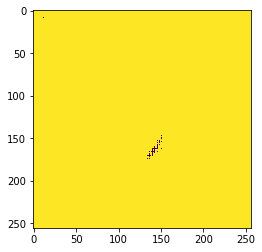

In [40]:
plt.imshow(model(data.one_batch()[0].cuda())[0].argmin(dim=1, keepdim=True)[0,0].cpu().numpy())

In [49]:
class CapsCallback(Callback):
    def __init__(self):
        self.hi = 1
            
    def on_loss_begin(self, last_output, train, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        last_output = last_output[0]
        
        '''if not train:
            sys.stdout.write(str(last_output[0].size()))
            last_output = last_output[0].argmax(dim=1, keepdims=True)'''
        return {'last_output':last_output}

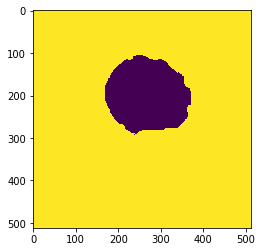

In [50]:
plt.imshow((1-data.train_ds.y[10].data).numpy()[0])

In [51]:
def channelify(mask):
    #bin mask shape 1,h,w
    zeroth = 1-mask
    return torch.cat((mask, zeroth), 1)


class BinLabelCallback(Callback):
    def __init__(self):
        self.learner=1

    def on_batch_begin(self, last_input, last_target, **kwargs):
        new_target = channelify(last_target)
        return {'last_input': last_input, 'last_target': new_target}
    
class BinLabelCallback(Callback):
    def __init__(self):
        self.learner=1

    def on_batch_begin(self, last_input, last_target, **kwargs):
        new_target = channelify(last_target)
        return {'last_input': last_input, 'last_target': new_target}

In [52]:
capsc = CapsCallback()
binc = BinLabelCallback()

In [53]:
model = one_group_selective_freeze(model, 'get_abstract_caps_final1')

#use this to see which modules of the model have had requires grad set to true and false

for n,c in model.named_children():
    for p in c.parameters():
        print(p.requires_grad)

In [54]:
caps_learner = Learner(data,model,loss_func=new_loss,metrics=metrics)

caps_learner.fit(1, lr = 0.0001, callbacks=[capsc])

In [55]:
lr = 0.0001
caps_learner.fit_one_cycle(1,slice(lr),pct_start=0.4,callbacks=[binc, capsc])

epoch,train_loss,valid_loss,acc,sens,spec,mydice,time
0,0.173588,0.154403,0.982572,0.981201,0.834952,0.990312,15:54


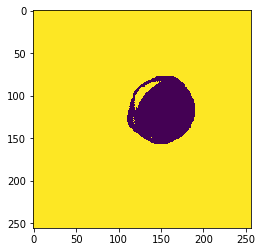

In [56]:
plt.imshow(caps_learner.model(data.one_batch()[0].cuda())[0].argmax(dim=1, keepdim=True)[0,0].cpu().numpy())

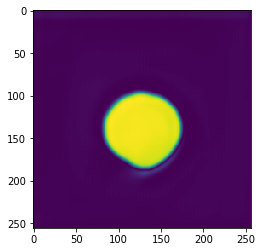

In [57]:
plt.imshow(caps_learner.model(data.one_batch()[0].cuda())[0][0,0])

In [58]:
caps_learner.model(data.one_batch()[0].cuda())[0].size()

torch.Size([1, 2, 256, 256])

In [107]:
def show_a_class_ps():
    fig, (axim, axl, axb, axlu, axpr) = plt.subplots(nrows=1, ncols=5, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
    
    batch = data.one_batch()
    
    im = axim.imshow(batch[0][0,0],'gray', interpolation='none')
    l = axl.imshow(batch[1][0][0],'gray', interpolation='none')
    
    background = axb.imshow(caps_learner.model(batch[0].cuda())[0][0,0])
    lumen = axlu.imshow(caps_learner.model(batch[0].cuda())[0][0,1])
    pred = axpr.imshow(caps_learner.model(batch[0].cuda())[0].argmin(dim=1, keepdim=True)[0,0])

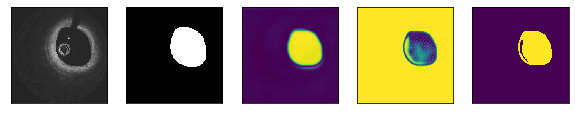

In [205]:
show_a_class_ps()

In [153]:
torch.save(caps_learner.model.state_dict(), Path('/workspace/oct_ca_seg/runsaves/capstuned.pt'))

In [ ]:
torch.load(Path('/workspace/oct_ca_seg/runsaves/capstuned.pt'))

In [61]:
def show_a_pred_and_pic(minmax):
    fig, (axim, axl, ax) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
    
    batch = data.one_batch()
    
    im = axim.imshow(batch[0][0,0],'gray', interpolation='none')
    l = axl.imshow(batch[1][0][0],'gray', interpolation='none')
    
    if minmax=='min':
        axp = ax.imshow(caps_learner.model(batch[0].cuda())[0].argmin(dim=1, keepdim=True)[0,0])
    if minmax=='max':
        axp = ax.imshow(caps_learner.model(batch[0].cuda())[0].argmax(dim=1, keepdim=True)[0,0])
    else:
        axp = ax.imshow(caps_learner.model(batch[0].cuda())[0][0,0])

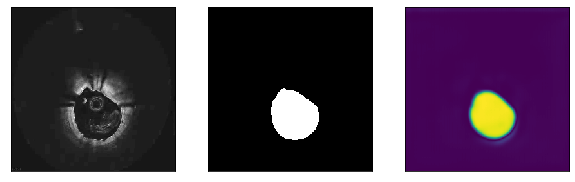

In [145]:
show_a_pred_and_pic('nil')

In [130]:
model_copy = caps_learner.model

In [144]:
#octoptimizer = optim.Adam(model_copy.parameters(), lr=0.00001,weight_decay=True)

for i, (xb, yb) in enumerate(data.train_dl):
    caps_learner.model.eval()
    xb, yb = xb, channelify(yb)
    pred, recon = caps_learner.model(xb)
    sn = sens(pred, yb)
    spn = spec(pred,yb)
    dn = mydice(pred, yb)
    accn = acc(pred,yb)
    break

AttributeError: 'Tensor' object has no attribute 'items'

In [131]:
sn,spn,dn,accn

(tensor(0.9939, device='cuda:0'),
 tensor(0.9321, device='cuda:0'),
 tensor(0.9969, device='cuda:0'),
 tensor(0.9944, device='cuda:0'))

In [143]:
data.train_dl.x.items

array([PosixPath('/workspace/oct_ca_seg/data_oct/images/0003001.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0007004.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0005308.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0004374.jpg'), ...,
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0007792.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0010471.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0005707.jpg'),
       PosixPath('/workspace/oct_ca_seg/data_oct/images/0006500.jpg')], dtype=object)

In [127]:
pred.size(), recon.size()

(torch.Size([1, 2, 256, 256]), torch.Size([2, 1, 256, 256]))

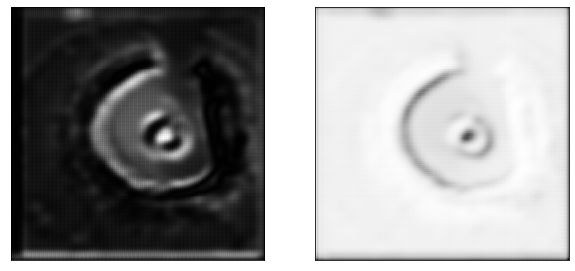

In [136]:
pred.cpu().detach().numpy()
recon.cpu().detach().numpy()

fig, (axim, axl) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})

im = axim.imshow(pred[0,0],'gray', interpolation='none')
l = axl.imshow(pred[0,1],'gray', interpolation='none')

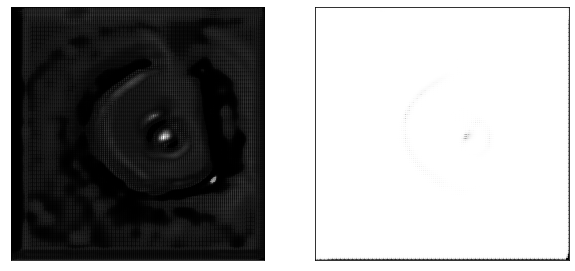

In [137]:
fig, (axim, axl) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10),
                    subplot_kw={'xticks': [], 'yticks': []})

im = axim.imshow(recon[0,0],'gray', interpolation='none')
l = axl.imshow(recon[1,0],'gray', interpolation='none')